In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


Importing the datasets train and test

In [2]:
# dataset
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

Analyzing the train and test datasets

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


Checking for missing values.

In [5]:
# summing up the missing values (column-wise) in train data set
sum(round(100*(train.isnull().sum()/len(train.index)), 2)>0)

0

In [6]:
# summing up the missing values (column-wise) in test data set
sum(round(100*(train.isnull().sum()/len(train.index)), 2)>0)

0

There are no missing values in columns, but lot of columns having only 0 values. We cannot drop these columns as they might be different for train and test sets, and as a result we might end up having different column sets for train and test data

In [7]:
train.nunique()==1

label       False
pixel0       True
pixel1       True
pixel2       True
pixel3       True
pixel4       True
pixel5       True
pixel6       True
pixel7       True
pixel8       True
pixel9       True
pixel10      True
pixel11      True
pixel12     False
pixel13     False
pixel14     False
pixel15     False
pixel16      True
pixel17      True
pixel18      True
pixel19      True
pixel20      True
pixel21      True
pixel22      True
pixel23      True
pixel24      True
pixel25      True
pixel26      True
pixel27      True
pixel28      True
            ...  
pixel754     True
pixel755     True
pixel756     True
pixel757     True
pixel758     True
pixel759     True
pixel760     True
pixel761    False
pixel762    False
pixel763    False
pixel764    False
pixel765    False
pixel766    False
pixel767    False
pixel768    False
pixel769    False
pixel770    False
pixel771    False
pixel772    False
pixel773    False
pixel774    False
pixel775    False
pixel776    False
pixel777    False
pixel778  

In [8]:
test.nunique()==1

pixel0       True
pixel1       True
pixel2       True
pixel3       True
pixel4       True
pixel5       True
pixel6       True
pixel7       True
pixel8       True
pixel9       True
pixel10      True
pixel11      True
pixel12      True
pixel13      True
pixel14      True
pixel15      True
pixel16      True
pixel17      True
pixel18      True
pixel19      True
pixel20      True
pixel21      True
pixel22      True
pixel23      True
pixel24      True
pixel25      True
pixel26      True
pixel27      True
pixel28      True
pixel29      True
            ...  
pixel754     True
pixel755     True
pixel756     True
pixel757     True
pixel758     True
pixel759     True
pixel760    False
pixel761    False
pixel762    False
pixel763    False
pixel764    False
pixel765    False
pixel766    False
pixel767    False
pixel768    False
pixel769    False
pixel770    False
pixel771    False
pixel772    False
pixel773    False
pixel774    False
pixel775    False
pixel776    False
pixel777    False
pixel778  

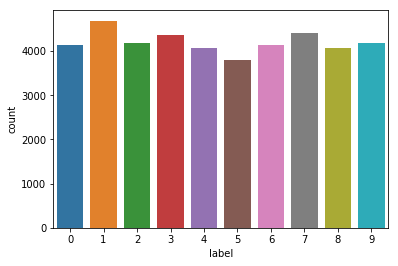

In [9]:
## Visualizing the number of class and counts in the datasets
sns.countplot(train["label"])

Text(0.5, 1.0, 'Digit 4')

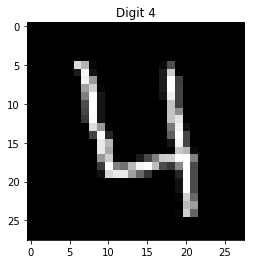

In [10]:
# Plotting some samples
four = train.iloc[3, 1:]
four.shape
four = four.values.reshape(28,28)
plt.imshow(four, cmap='gray')
plt.title("Digit 4")

Text(0.5, 1.0, 'Digit 7')

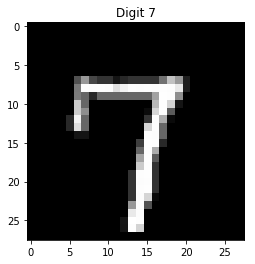

In [11]:
seven = train.iloc[6, 1:]
seven.shape
seven = seven.values.reshape(28, 28)
plt.imshow(seven, cmap='gray')
plt.title("Digit 7")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


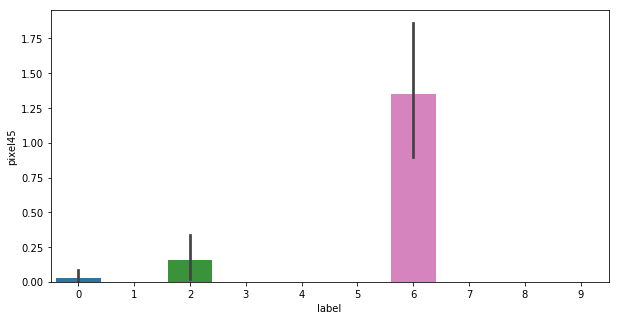

In [12]:
# basic plots: How do various pixels vary with the digits

plt.figure(figsize=(10, 5))
sns.barplot(x='label', y='pixel45', 
            data=train)

Checking for rows which are completely zero in both train and test daasets, and deleting only those columns which have 0 values in both, else we will end upm havinmg different column sets for train and test.

In [13]:
train_1 = train.drop('label',axis=1)

In [14]:
zero_val_cols_removal = pd.DataFrame(((train_1 != 0).any(axis=0) &  (test != 0).any(axis=0))==False)

In [15]:
zero_val_cols_removal.reset_index(inplace=True)


In [16]:
zero_val_cols_removal.columns = ['col_name','is_zero']

In [17]:
for col_name in zero_val_cols_removal.loc[(zero_val_cols_removal.is_zero==True),'col_name']:
    train.drop(col_name,axis=1,inplace=True)
    test.drop(col_name,axis=1,inplace=True)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 691 entries, label to pixel778
dtypes: int64(691)
memory usage: 221.4 MB


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 690 entries, pixel33 to pixel778
dtypes: int64(690)
memory usage: 147.4 MB


Columns have now been reduced from 785 to 691 for train and 784 tom 690 for test, one less in test due to the absence of label columnm

Since train dataset is having 42000 rows which would take a long time with GridSearchCV with 5 folds to find optimal values of hyperparameters, we will takme Sub Sample of data like 20% of the train data here.m 

In [20]:
train_sample = train.sample(frac =.20,random_state=10) 

In [21]:
train_sample.head()

,label,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,...,pixel725,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778
27084,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,13,148,221,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18640,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41477,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39744,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28354,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,95,255,149,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8400 entries, 27084 to 16109
Columns: 691 entries, label to pixel778
dtypes: int64(691)
memory usage: 44.3 MB


Seperating the prediction label and the pixel columns for the train set

In [23]:
X_train = train_sample.drop('label',axis=1)
y_train = train_sample['label']

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


First we will fit a linear SVM model with varying values of C using GridSearchCV and KFold and check which C gives best accuracy

In [25]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of parameters (C) as a list
params = {"C": [0.1, 1, 10, 100, 1000]}

model_linear = SVC(kernel='linear', cache_size=10000)

# set up grid search scheme
# note that we are still using the 5 fold CV scheme we set up earlier
model_cv = GridSearchCV(estimator = model_linear, 
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=-1)      

In [26]:
# fit the model - it will fit 5 folds across all values of C
model_cv.fit(X_train, y_train)  

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=10000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.1, 1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=1)

In [27]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,12.166855,0.752576,4.608649,0.068401,0.1,{'C': 0.1},0.903571,0.917857,0.915476,0.915476,0.919048,0.914286,0.005533,1,0.999702,0.999851,0.999554,0.999702,0.999702,0.999702,0.000094
1,10.980175,0.102210,4.630438,0.050429,1,{'C': 1},0.907143,0.916667,0.911310,0.914881,0.919643,0.913929,0.004335,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,10.921982,0.180107,4.631491,0.068309,10,{'C': 10},0.907143,0.916667,0.911310,0.914881,0.919643,0.913929,0.004335,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,10.991248,0.153515,4.653064,0.067270,100,{'C': 100},0.907143,0.916667,0.911310,0.914881,0.919643,0.913929,0.004335,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,10.868653,0.931066,4.542650,0.368082,1000,{'C': 1000},0.907143,0.916667,0.911310,0.914881,0.919643,0.913929,0.004335,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


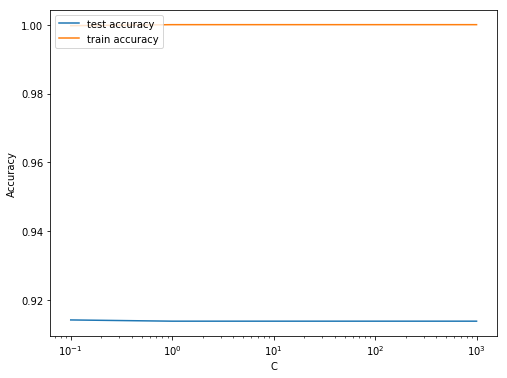

In [28]:
# plot of C versus train and test scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [29]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9142857142857143 corresponding to hyperparameters {'C': 0.1}


The best train data accuracy that we got is 0.9142 for c=0.1. We will use this to predict the test labels and check for the accuracy score and ranking in kaggle.

In [30]:
# model with optimal hyperparameters

# model
model = SVC(C=0.1,  kernel="linear")

model.fit(X_train, y_train)
y_pred = model.predict(test)

In [31]:
y_pred = pd.DataFrame(y_pred)

In [32]:
y_pred.head()

,0
0,2
1,0
2,9
3,4
4,3


In [33]:
y_pred.reset_index(inplace=True)

In [34]:
y_pred.head()

,index,0
0,0,2
1,1,0
2,2,9
3,3,4
4,4,3


In [35]:
y_pred.columns = ['ImageId','Label']

In [36]:
y_pred.ImageId = y_pred.ImageId + 1

In [37]:
y_pred.to_csv('result_linear.csv', index=False)

This one scored  0.91457 on kaggle. I have a higher score of 0.91914 which ranked 2514, but that was with more than 20% subsampling

Further we will check for other SVM kernels Polynomial and RBF

Now lets run Polynomial SVM on train data with varying values of C, gamma, and degree

In [38]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of parameters (C) as a list
hyper_params = [ {'gamma': [1e-1, 1e-2],
                      'C': [0.1, 1],
                 'degree': [2,3]
                 }]


model_poly = SVC(kernel='poly', cache_size=10000)

# set up grid search scheme
# note that we are still using the 5 fold CV scheme we set up earlier
model_cv = GridSearchCV( estimator = model_poly, 
                         param_grid = hyper_params, 
                         scoring= 'accuracy', 
                         cv = folds, 
                         verbose = 1,
                         return_train_score=True,
                         n_jobs=-1)      

In [39]:
# fit the model - it will fit 5 folds across all values of C, gamma and degree
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 11.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=10000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'gamma': [0.1, 0.01], 'C': [0.1, 1], 'degree': [2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [40]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,27.205464,0.402627,7.313543,0.042708,0.1,2,0.1,"{'C': 0.1, 'degree': 2, 'gamma': 0.1}",0.945833,0.938690,0.955952,0.945238,0.945833,0.946310,0.005525,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,28.668513,0.321330,7.390315,0.031817,0.1,2,0.01,"{'C': 0.1, 'degree': 2, 'gamma': 0.01}",0.948810,0.940476,0.955357,0.944643,0.947024,0.947262,0.004917,5,0.997470,0.997321,0.996280,0.996875,0.997173,0.997024,0.000421
2,38.157548,0.868027,7.828751,0.154283,0.1,3,0.1,"{'C': 0.1, 'degree': 3, 'gamma': 0.1}",0.947024,0.948214,0.958929,0.949405,0.946429,0.950000,0.004580,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,37.481229,0.512825,7.786760,0.063080,0.1,3,0.01,"{'C': 0.1, 'degree': 3, 'gamma': 0.01}",0.944643,0.948810,0.958333,0.950595,0.945833,0.949643,0.004830,4,0.999702,0.999851,0.999702,0.999851,0.999851,0.999792,0.000073
4,25.089251,0.298687,7.272699,0.073224,1,2,0.1,"{'C': 1, 'degree': 2, 'gamma': 0.1}",0.945833,0.938690,0.955952,0.945238,0.945833,0.946310,0.005525,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,25.185799,0.298601,7.304323,0.121426,1,2,0.01,"{'C': 1, 'degree': 2, 'gamma': 0.01}",0.945833,0.938690,0.955952,0.945238,0.946429,0.946429,0.005520,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,35.929097,0.301570,7.744857,0.060445,1,3,0.1,"{'C': 1, 'degree': 3, 'gamma': 0.1}",0.947024,0.948214,0.958929,0.949405,0.946429,0.950000,0.004580,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,36.176260,0.437249,7.734181,0.114870,1,3,0.01,"{'C': 1, 'degree': 3, 'gamma': 0.01}",0.947024,0.948214,0.958929,0.949405,0.946429,0.950000,0.004580,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


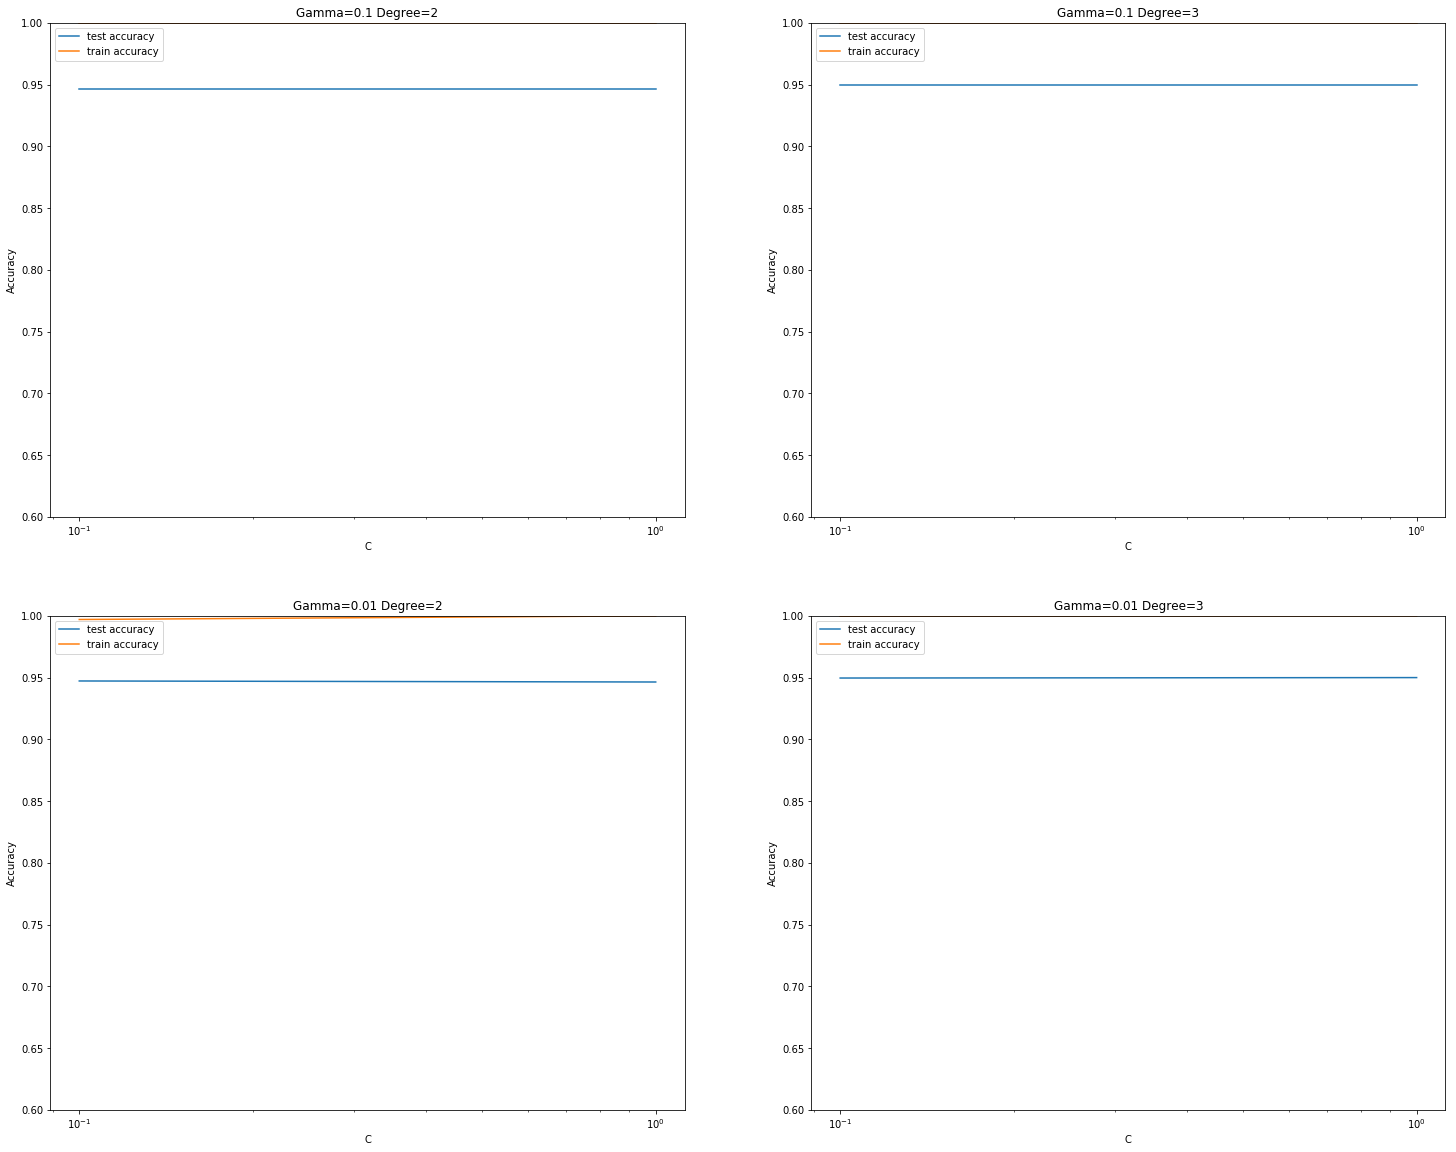

In [41]:
# # plotting
plt.figure(figsize=(25,20))

# subplot 4/1
plt.subplot(221)
gamma_1_degree_2 = cv_results.loc[(cv_results.param_gamma==0.1) & (cv_results.param_degree==2)]

plt.plot(gamma_1_degree_2["param_C"], gamma_1_degree_2["mean_test_score"])
plt.plot(gamma_1_degree_2["param_C"], gamma_1_degree_2["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.1 Degree=2")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 4/2
plt.subplot(222)
gamma_1_degree_3 = cv_results.loc[(cv_results.param_gamma==0.1) & (cv_results.param_degree==3)]

plt.plot(gamma_1_degree_3["param_C"], gamma_1_degree_3["mean_test_score"])
plt.plot(gamma_1_degree_3["param_C"], gamma_1_degree_3["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.1 Degree=3")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 4/3
plt.subplot(223)
gamma_01_degree_2 = cv_results.loc[(cv_results.param_gamma==0.01) & (cv_results.param_degree==2)]

plt.plot(gamma_01_degree_2["param_C"], gamma_01_degree_2["mean_test_score"])
plt.plot(gamma_01_degree_2["param_C"], gamma_01_degree_2["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01 Degree=2")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 4/4
plt.subplot(224)
gamma_01_degree_3 = cv_results.loc[(cv_results.param_gamma==0.01) & (cv_results.param_degree==3)]

plt.plot(gamma_01_degree_3["param_C"], gamma_01_degree_3["mean_test_score"])
plt.plot(gamma_01_degree_3["param_C"], gamma_01_degree_3["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01 Degree=3")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


In [42]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.95 corresponding to hyperparameters {'C': 0.1, 'degree': 3, 'gamma': 0.1}


So the best score here for Polynomial SVM is for gamma 0.1, degree 3, C 0.1. We will run the model now for these values again, predict scores and check for accuracy in kaggle.

In [43]:
# model with optimal hyperparameters

# model
model = SVC(C=0.1, degree=3, gamma=0.1, kernel="poly")

model.fit(X_train, y_train)
y_pred = model.predict(test)

In [44]:
y_pred = pd.DataFrame(y_pred)

In [45]:
y_pred.head()

,0
0,2
1,0
2,9
3,4
4,3


In [46]:
y_pred.reset_index(inplace=True)

In [47]:
y_pred.head()

,index,0
0,0,2
1,1,0
2,2,9
3,3,4
4,4,3


In [48]:
y_pred.columns = ['ImageId','Label']

In [49]:
y_pred.ImageId = y_pred.ImageId + 1

In [50]:
y_pred.to_csv('result_polynomial.csv', index=False)

This file scored 0.95371 with a rank of 2343 on kaggle.

Now we will move on to using RBF SVM and check for the accuracy that it gives. Here we will train the models for varying values of C and Gamma.

In [2]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of parameters (C) as a list
hyper_params = [ {'C': [0.001, 0.01 ,0.1, 1, 10, 100]
                 }]


model_poly = SVC(kernel='linear', cache_size=10000)

# set up grid search scheme
# note that we are still using the 5 fold CV scheme we set up earlier
model_cv = GridSearchCV( estimator = model_poly, 
                         param_grid = hyper_params, 
                         scoring= 'accuracy', 
                         cv = folds, 
                         verbose = 1,
                         return_train_score=True,
                         n_jobs=-1)      

NameError: name 'KFold' is not defined

In [52]:
# fit the model - it will fit 5 folds across all values of C and gamma
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 27.6min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=10000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'gamma': [0.1, 0.01, 0.001], 'C': [0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [53]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,117.163072,0.385562,16.256371,0.062185,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.108929,0.114286,0.117262,0.119048,0.103571,0.112619,0.005677,9,0.113542,0.112202,0.111458,0.111012,0.114881,0.112619,0.001419
1,103.316871,3.592330,15.028441,0.106376,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.315476,0.335119,0.300595,0.360714,0.391071,0.340595,0.032291,6,0.364583,0.375744,0.345536,0.418304,0.454911,0.391815,0.039558
2,47.068288,1.964438,12.377572,0.130369,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",0.863690,0.877381,0.874405,0.879762,0.883333,0.875714,0.006686,3,0.889137,0.888690,0.889583,0.887649,0.890625,0.889137,0.000983
3,110.217766,0.954319,15.951190,0.119512,1,0.1,"{'C': 1, 'gamma': 0.1}",0.163095,0.176190,0.154762,0.166071,0.167262,0.165476,0.006911,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,93.225268,1.675985,13.472256,0.124620,1,0.01,"{'C': 1, 'gamma': 0.01}",0.730952,0.747619,0.745833,0.749405,0.756548,0.746071,0.008389,5,0.999851,0.999702,0.999554,0.999702,0.999702,0.999702,0.000094
5,23.021878,0.465528,7.724715,0.144563,1,0.001,"{'C': 1, 'gamma': 0.001}",0.925000,0.927381,0.936905,0.933929,0.932738,0.931190,0.004368,2,0.974554,0.975000,0.973363,0.971429,0.973512,0.973571,0.001236
6,112.951018,1.125365,15.945282,0.167867,10,0.1,"{'C': 10, 'gamma': 0.1}",0.167857,0.180952,0.156548,0.170833,0.170238,0.169286,0.007794,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,97.119669,1.713075,13.568559,0.117202,10,0.01,"{'C': 10, 'gamma': 0.01}",0.746429,0.763095,0.764881,0.775000,0.771429,0.764167,0.009863,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,19.552458,0.945571,6.724597,0.339538,10,0.001,"{'C': 10, 'gamma': 0.001}",0.938690,0.939286,0.948214,0.943452,0.942262,0.942381,0.003417,1,0.999554,0.999554,0.999107,0.999554,0.999554,0.999464,0.000179


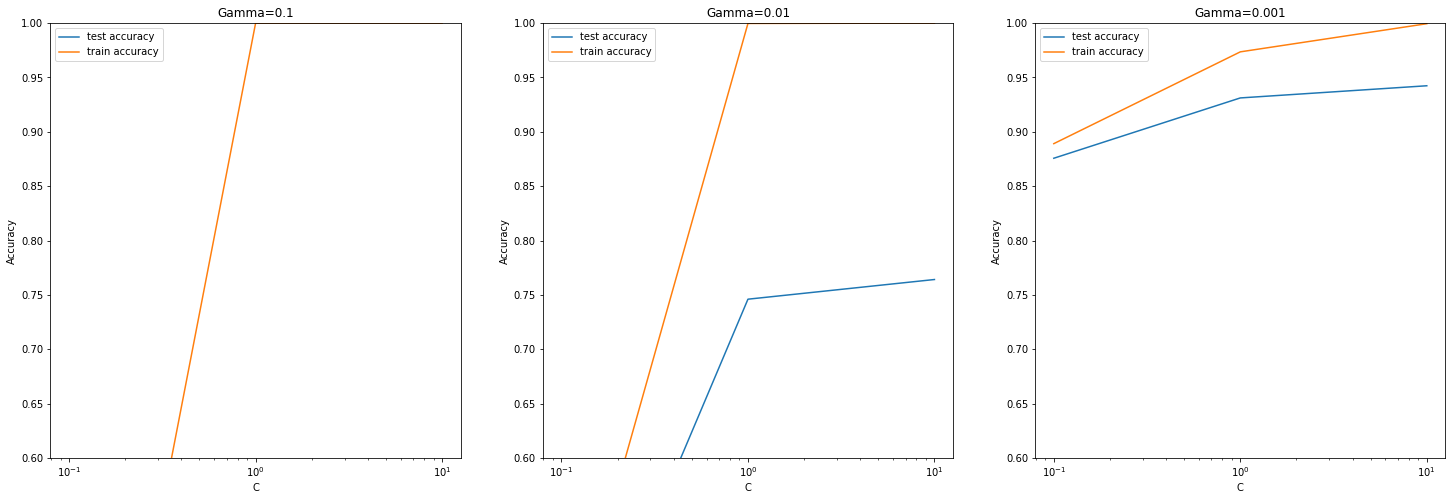

In [54]:
# # plotting
plt.figure(figsize=(25,8))

# subplot 3/1
plt.subplot(131)
gamma_1 = cv_results.loc[(cv_results.param_gamma==0.1)]

plt.plot(gamma_1["param_C"], gamma_1["mean_test_score"])
plt.plot(gamma_1["param_C"], gamma_1["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.1")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 3/2
plt.subplot(132)
gamma_01 = cv_results.loc[(cv_results.param_gamma==0.01)]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 3/3
plt.subplot(133)
gamma_001 = cv_results.loc[(cv_results.param_gamma==0.001)]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


In [55]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9423809523809524 corresponding to hyperparameters {'C': 10, 'gamma': 0.001}


The best score for rbf(0.9423) was for c=10 and gamma=0.001. we will train the model indivisually with these values and use it to predict test labels.

In [56]:
# model with optimal hyperparameters

# model
model = SVC(C=10, gamma=0.001, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(test)

In [57]:
y_pred = pd.DataFrame(y_pred)

In [58]:
y_pred.head()

,0
0,2
1,0
2,9
3,4
4,3


In [59]:
y_pred.reset_index(inplace=True)

In [60]:
y_pred.head()

,index,0
0,0,2
1,1,0
2,2,9
3,3,4
4,4,3


In [61]:
y_pred.columns = ['ImageId','Label']

In [62]:
y_pred.ImageId = y_pred.ImageId + 1

In [63]:
y_pred.to_csv('result_rbf.csv', index=False)

This file scored 0.94442  on kaggle.

So we got accuracies with different methods with 20% sub-Sampled data as below:
    1. SVM with Linear Kernel: 0.91457
    2. SVM with Polynomial Kernel: 0.95371 (This was my personal best rank for this problem statement : 2343)
    3. SVM with RBF Kernel: 0.94442    
Also note that I have ran this Kernel on Kaggle Directly as running it on my laptop was very slow due to small RAM size etc.